# H2 dissociation in Hartree-Fock

In this notebook we calculate the H2 dissociation curve for different crmult in the restricted Hartree-Fock approximation. The reference for one atom is calculated using 0.5 as occupation number given a wrong value of energy.

In [1]:
import os,sys,commands,shutil
import numpy as np

os.environ["OMP_NUM_THREADS"]="4" #depends on your computer (compiled with OpenMP)

def run_bigdft(prefix,yaml,xyz,scratch=False):
    """Run a BigDFT calculation if the file log-prefix.yaml does not exist!
       If scratch is true, then do always the calculation."""
    BigDFT = os.environ["BIGDFT_ROOT"]+"/bigdft"
    if scratch or not os.path.exists("log-"+prefix+".yaml"):
        open(prefix+".yaml","w").write(yaml)
        open(prefix+".xyz","w").write(xyz)
        sys.stdout.write(prefix + " ... ")
        sys.stdout.flush()
        output = commands.getstatusoutput("%s --name=%s" % (BigDFT,prefix))
        sys.stdout.write(str(output) + "\n")
    else:
        print "Logfile log-%s.yaml does already exist!" % prefix
        
#Extract the archive if it exists to avoid running all calculations
tarname = 'log-H2-HF-dissociation.tar.bz2'
if os.path.exists(tarname):
    print "The tar file %s with all log files exists: we use it avoiding calculations!" % tarname
    import tarfile
    tar = tarfile.open(tarname,"r:bz2")
    #for n in tar.getmembers(): 
    #    print n.name
    tar.extractall()
    tar.close()

The tar file log-H2-HF-dissociation.tgz with all log files exists: we use it avoiding calculations!


We do all the calculations...

In [2]:
H_xyz = """\
1 angstroemd0
free
H 0 0 0
"""

def dimer_xyz(d):
    d_xyz = """\
2 angstroemd0
free
H 0 0 0
H 0 0 {0:14.12f}"""
    return d_xyz.format(d)

#cubic calculations
def cubic_yaml(d):
    cubic = """\
 dft:
   hgrids: 0.40
   gnrm_cv: 1.e-9
   rmult: [{0:14.12f}, 7.0]
   ixc: HF
   itermax: 150
 psppar.H:
   Pseudopotential type                : HGH-K
   Atomic number                       : 1
   No. of Electrons                    : 1
   Pseudopotential XC                  : 1
   Local Pseudo Potential (HGH convention):
     Rloc                              : 0.2
     Coefficients (c1 .. c4): [-4.1802368, 0.72507482, 0.0, 0.0]
   Radii of active regions (AU):
     Coarse                            : 1.463418464633951
     Fine                              : 0.2
     Coarse PSP                        : 0."""   
    return cubic.format(d)

#reference for the hydrogen atom with a large crmult
run_bigdft("H-HF-%05.2f" % 15.0,yaml=cubic_yaml(15),xyz=H_xyz)

dists = [0.3,0.4,0.5,0.6,0.7,0.9,1.0,2.0,4.0,5.0,6.0,8.0,10.0]
crmult = [3, 6, 9, 12]

for r in crmult:
    #First do the calculaltion with the hydrogen atom
    run_bigdft("H-HF-%05.2f" % r,yaml=cubic_yaml(r),xyz=H_xyz)
    for d in dists:
        prefix = "H2-HF-%05.2f-%05.2f" % (r,d)
        run_bigdft(prefix,yaml=cubic_yaml(r),xyz=dimer_xyz(d))

Logfile log-H-HF-15.00.yaml does already exist!
Logfile log-H-HF-03.00.yaml does already exist!
Logfile log-H2-HF-03.00-00.30.yaml does already exist!
Logfile log-H2-HF-03.00-00.40.yaml does already exist!
Logfile log-H2-HF-03.00-00.50.yaml does already exist!
Logfile log-H2-HF-03.00-00.60.yaml does already exist!
Logfile log-H2-HF-03.00-00.70.yaml does already exist!
Logfile log-H2-HF-03.00-00.90.yaml does already exist!
Logfile log-H2-HF-03.00-01.00.yaml does already exist!
Logfile log-H2-HF-03.00-02.00.yaml does already exist!
Logfile log-H2-HF-03.00-04.00.yaml does already exist!
Logfile log-H2-HF-03.00-05.00.yaml does already exist!
Logfile log-H2-HF-03.00-06.00.yaml does already exist!
Logfile log-H2-HF-03.00-08.00.yaml does already exist!
Logfile log-H2-HF-03.00-10.00.yaml does already exist!
Logfile log-H-HF-06.00.yaml does already exist!
Logfile log-H2-HF-06.00-00.30.yaml does already exist!
Logfile log-H2-HF-06.00-00.40.yaml does already exist!
Logfile log-H2-HF-06.00-00.50.y

We collect all information (the names of the log files are useless).

In [3]:
from BigDFT import Logfiles as lf
import glob

#Collect the data
HtoeV = 27.211396132 #Conversion Hartree to meV

#First the reference
lfiles = glob.glob('log-H-HF-*.yaml')
lfiles.sort()
ref = {'rmult': [], 'energies': [], 'gnrm_cv': [], 'gnrm': [], 'legend': 'H-HF'}
for fname in lfiles:
    print fname,
    log = lf.Logfile(fname)
    r = float(log.log['dft']['rmult'][0])
    ref['rmult'].append(r)
    ref['gnrm_cv'].append(log.gnrm_cv)
    ref['gnrm'].append(lf.find_iterations(log.log)[-1][-1])
    ref['energies'].append( HtoeV*log.energy)

#Then the dissociation curve
lfiles = glob.glob('log-H2-HF-*.yaml')
lfiles.sort()
data = {'rmult': [], 'distances': [], 'energies': [], 'forcemax': [], 'gnrm': [], 'legend': 'H2-HF'}
distances = []
crmult = []
for fname in lfiles:
    print fname,
    log = lf.Logfile(fname)
    r = float(log.log['dft']['rmult'][0])
    d = float(log.log['posinp']['positions'][1]['H'][2])
    if r not in crmult: 
        crmult.append(r)
    if d not in distances:
        distances.append(d)
    #Use the reference from one Hydrogen atom calculation.
    H = lf.Logfile('log-H-HF-%05.2f.yaml' % r)
    data['rmult'].append(r)
    data['distances'].append(d)
    data['energies'].append( HtoeV*(log.energy - 2.0* H.energy) )
    #data['gnrm_cv'].append(log.gnrm_cv)
    data['gnrm'].append(lf.find_iterations(log.log)[-1][-1])
    data['forcemax'].append(log.forcemax)
#print data
#We sort the distances and crmult
crmult.sort()
distances.sort()
print "\nThere are %d different crmult and %d different distances." % (len(crmult),len(distances))

log-H-HF-03.00.yaml log-H-HF-06.00.yaml log-H-HF-09.00.yaml log-H-HF-12.00.yaml log-H-HF-15.00.yaml log-H2-HF-03.00-00.30.yaml log-H2-HF-03.00-00.40.yaml log-H2-HF-03.00-00.50.yaml log-H2-HF-03.00-00.60.yaml log-H2-HF-03.00-00.70.yaml log-H2-HF-03.00-00.90.yaml log-H2-HF-03.00-01.00.yaml log-H2-HF-03.00-02.00.yaml log-H2-HF-03.00-04.00.yaml log-H2-HF-03.00-05.00.yaml log-H2-HF-03.00-06.00.yaml log-H2-HF-03.00-08.00.yaml log-H2-HF-03.00-10.00.yaml log-H2-HF-06.00-00.30.yaml log-H2-HF-06.00-00.40.yaml log-H2-HF-06.00-00.50.yaml log-H2-HF-06.00-00.60.yaml log-H2-HF-06.00-00.70.yaml log-H2-HF-06.00-00.90.yaml log-H2-HF-06.00-01.00.yaml log-H2-HF-06.00-02.00.yaml log-H2-HF-06.00-04.00.yaml log-H2-HF-06.00-05.00.yaml log-H2-HF-06.00-06.00.yaml log-H2-HF-06.00-08.00.yaml log-H2-HF-06.00-10.00.yaml log-H2-HF-09.00-00.30.yaml log-H2-HF-09.00-00.40.yaml log-H2-HF-09.00-00.50.yaml log-H2-HF-09.00-00.60.yaml log-H2-HF-09.00-00.70.yaml log-H2-HF-09.00-00.90.yaml log-H2-HF-09.00-01.00.yaml log-H2-HF

## Convergence of the energy for the Hydrogen atom in function of rmult

The reference of total energy is -6.6372804071  eV ( -0.243915467435  Hartree).


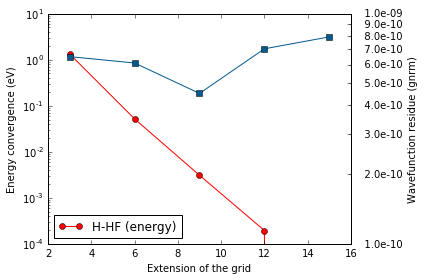

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

ener = [ abs(e - ref['energies'][-1]) for e in ref['energies']]
print "The reference of total energy is",ref['energies'][-1]," eV (",ref['energies'][-1]/HtoeV," Hartree)."

fig, ax1 = plt.subplots()
ax1.set_yscale('log')
ax1.set_xlabel('Extension of the grid')
ax1.set_ylabel('Energy convergence (eV)')
ax1.plot(ref['rmult'], ener, marker=markers[0], 
             ls='-', label=ref['legend']+' (energy)', color=colors[1])
ax1.legend(loc=3)

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylim(1.e-10,1.e-9)
ax2.set_yticks(np.arange(1.e-10,1.1e-9,1.e-10))
ax2.set_yticklabels([ "%10.1e" % i for i in np.arange(1.e-10,1.1e-9,1.e-10)])
ax2.set_ylabel('Wavefunction residue (gnrm)')
ax2.plot(ref['rmult'], ref['gnrm'], marker=markers[1], 
             ls='-', label=ref['legend'], color=colors[2])
fig.tight_layout()
plt.show()

## H2 dissociation energy curve for different rmult

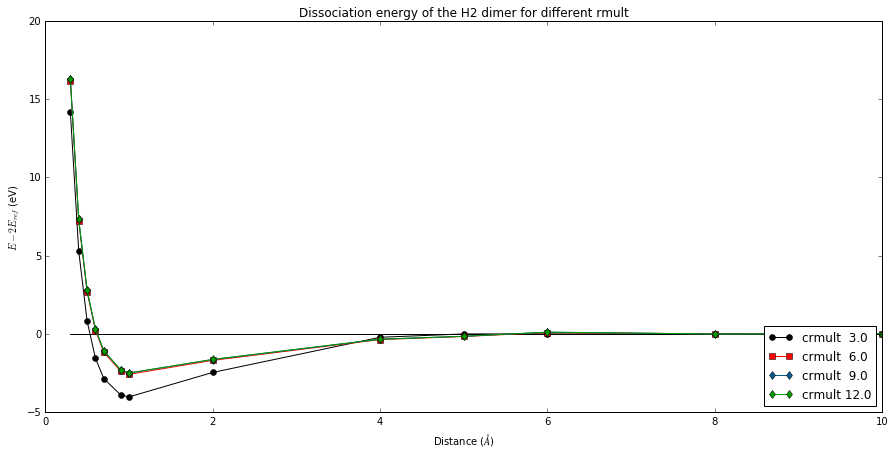

In [5]:
#Build the curve
curves = [ {'energies': [], 'distances': [], 'legend': "crmult %4.1f" % r} for r in crmult]
for (r,d,e) in zip(data['rmult'],data['distances'],data['energies']):
    i = crmult.index(float(r))
    curves[i]['energies'].append(e)
    curves[i]['distances'].append(d)

import matplotlib.pyplot as plt
import numpy as np
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(15,7))
# Plot with matplotlib
for i, dat in enumerate(curves):
    im = i%len(colors)
    if i == 0: plt.plot(dat['distances'],np.zeros_like(dat['energies']),'k-')
    plt.plot(dat['distances'], dat['energies'], marker=markers[im], 
             ls='-', label=dat['legend'],color=colors[im])  

#plt.ylim([-1, 0.5])
#plt.xlim([6.0, 10.0])
plt.xlabel('Distance ($\AA$)')
plt.ylabel('$E-2E_{ref}$ (eV)')
plt.title('Dissociation energy of the H2 dimer for different rmult')
plt.legend(loc=4)
plt.show()

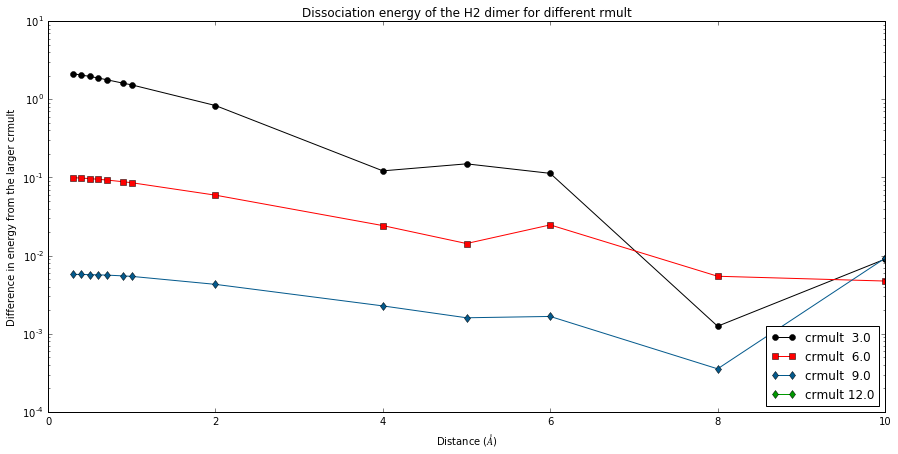

In [6]:
#Build the curve
curves = [ {'energies': [], 'distances': [], 'legend': "crmult %4.1f" % r} for r in crmult]
for (r,d,e) in zip(data['rmult'],data['distances'],data['energies']):
    i = crmult.index(float(r))
    curves[i]['energies'].append(e)
    curves[i]['distances'].append(d)

import matplotlib.pyplot as plt
import numpy as np
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(15,7))
# Plot with matplotlib
for i, dat in enumerate(curves):
    im = i%len(colors)
    #if i == 0: plt.plot(dat['distances'],np.zeros_like(dat['energies']),'k-')
    diff = [ abs(d-e) for (d,e) in zip(dat['energies'],curves[-1]['energies'])]
    plt.plot(dat['distances'], diff, marker=markers[im], 
             ls='-', label=dat['legend'],color=colors[im])  

#plt.ylim([-1.0, 0])
#plt.xlim([0.3, 5.0])
plt.yscale('log')
plt.xlabel('Distance ($\AA$)')
plt.ylabel('Difference in energy from the larger crmult')
plt.title('Dissociation energy of the H2 dimer for different rmult')
plt.legend(loc=4)
plt.show()

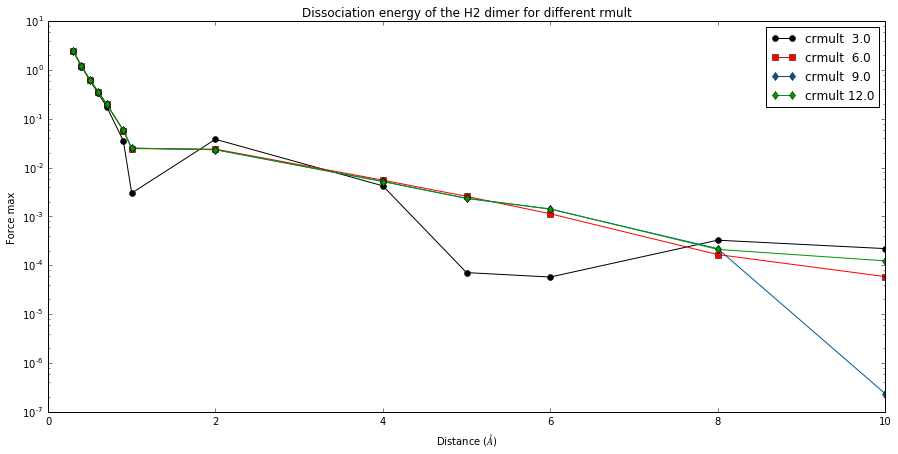

In [7]:
#Build the curve
curves = [ {'forcemax': [], 'distances': [], 'legend': "crmult %4.1f" % r} for r in crmult]
for (r,d,e) in zip(data['rmult'],data['distances'],data['forcemax']):
    i = crmult.index(float(r))
    curves[i]['forcemax'].append(e)
    curves[i]['distances'].append(d)

import matplotlib.pyplot as plt
import numpy as np
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(15,7))
# Plot with matplotlib
for i, dat in enumerate(curves):
    im = i%len(colors)
    if i == 0: plt.plot(dat['distances'],np.zeros_like(dat['forcemax']),'k-')
    plt.plot(dat['distances'], dat['forcemax'], marker=markers[im], 
             ls='-', label=dat['legend'],color=colors[im])  

#plt.ylim([-1.0, 0])
#plt.xlim([0.3, 5.0])
plt.yscale('log')
plt.xlabel('Distance ($\AA$)')
plt.ylabel('Force max')
plt.title('Dissociation energy of the H2 dimer for different rmult')
plt.legend(loc=1)
plt.show()

## H2 dissociation energy in function of rmult

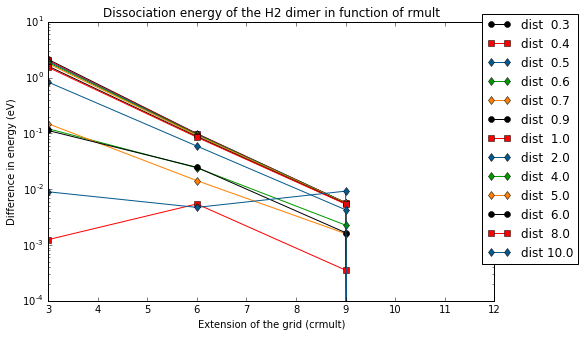

In [8]:
#Build the curve
curves = [ {'energies': [], 'rmult': [], 'legend': "dist %4.1f" % d} for d in distances]
for (r,d,e) in zip(data['rmult'],data['distances'],data['energies']):
    i = distances.index(float(d))
    curves[i]['energies'].append(e)
    curves[i]['rmult'].append(r)

import matplotlib.pyplot as plt
import numpy as np
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(8,5))
# Plot with matplotlib
for i, dat in enumerate(curves):
    im = i%len(colors)
    diff = [ abs(d - dat['energies'][-1]) for d in dat['energies']]
    plt.plot(dat['rmult'], diff, marker=markers[im], 
             ls='-', label=dat['legend'], color=colors[im])
#plt.plot(data['rmult'],np.zeros_like(data['energies']),'k-')
#plt.ylim([-1.0, 0])
#plt.xlim([0.3, 5.0])
plt.yscale('log')
plt.xlabel('Extension of the grid (crmult)')
plt.ylabel('Difference in energy (eV)')
plt.title('Dissociation energy of the H2 dimer in function of rmult')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

To avoid running all calculation, we create two archive tar file:
* one containing all logs _log-dimer*_
* another one containing all data for the templates (_log-h2o*_ and mainly _data-h2o*_)

In [10]:
#First archive file (log to analyse)
if not os.path.exists(tarname):
    import tarfile
    tar = tarfile.open(tarname,"w:bz2")
    for name in glob.glob("log-H*.yaml"):
        tar.add(name)
    tar.close()
    print "Creation of a tar file with all log files: %s" % tarname
else:
    print "No creation of tarfile %s because it already exists!" % tarname

No creation of tarfile log-H2-LDA-dissociation.tgz because it already exists!
